## MBDoE analysis with finite difference method 

This notebook runs MBDoE analysis with finite difference method. 

In [1]:
import numpy as np 
import pickle
import matplotlib.pyplot as plt

In [2]:
def load_pickle(name): 
    """Used for loading data from pickle file 
    """
    file = open(name, "rb")
    data = pickle.load(file)
    file.close()
    return data
def save_pickle(data, name):
    """Used for saving data to pickle file 
    """
    file = open(name, "wb")
    pickle.dump(data, file)
    file.close()

### Define parameters

In [3]:
# parameter nominal values
parameter = {
    "C1": 2.562434e-12, 
    "hgx": 25 * 1e-3, 
    "delH_1": 98.76,
    "delH_2": 77.11, 
    "delH_3": 21.25
}
# number of parameters
n_para =len(parameter)
# parameter name list
parameter_names = list(parameter.keys())

### Define measurement names and locations

In [4]:
## Get measurement names 
measure_keys = ["y_CO2", "P", "vg", "Tg", "Ts"]
# measurements from MO results
measure_list = [
    "ads/y_CO2/1/0.1",
    "ads/y_CO2/1/0.796", 
    "des/y_CO2/0/0.349",
    "des/y_CO2/0/0.398",
    "des/y_CO2/0/0.896",
    "des/y_CO2/0.115/0.349",
    "des/y_CO2/0.188/0.349", 
    "des/y_CO2/0.5/0.896",
]

In [6]:
def gradient(upper, lower, original, step, param_value, 
             option="scale_parameter", 
             finite_diff_option="central"):
    """
    Finite difference calculation 
    
    Arguments
    ---------
    upper: float
        measurement value with forward perturbing the parameters 
    lower: float
        measurement value with backward perturbing the parameters 
    original: float
        measurement value not perturbing the parameters 
    step: float
        step size
    param_value: float
        the parameter nominal value that is perturbed 
    option: string 
        choose from "scale_parameter", "not_scale_parameter", "scale_para_and_measure"
        decide if the stepsize is scaled by the parameter nominal value
        and if the measurement is scaled by the measurement value 
    finite_diff_option: string
        choose from "upper", "lower", "central"
        upper means forward FD, lower means backward FD, central means central FD
    """
    # central finite difference
    if finite_diff_option=="central":
        if option=="scale_parameter":
            return (upper-lower)/2/step
        elif option=="not_scale_parameter":
            return (upper-lower)/2/step/param_value
        elif option=="scale_para_and_measure":
            return (upper/original-lower/original)/2/step
    # forward finite difference
    elif finite_diff_option=="upper":
        if option=="scale_parameter":
            return (upper-original)/step
        elif option=="not_scale_parameter":
            return (upper-original)/step/param_value
        elif option=="scale_para_and_measure":
            return (upper/original-1)/step
    # backward finite difference
    elif finite_diff_option=="lower":
        if option=="scale_parameter":
            return (original-lower)/step
        elif option=="not_scale_parameter":
            return (original-lower)/step/param_value
        elif option=="scale_para_and_measure":
            return (original-lower)/step
    else:
        raise ValueError("Finite_diff_option should be upper, lower, or central")

In [8]:
def convert_tuple(file):
    """
    This function gets a dictionary, and round the fractions in the 
    keys to 3 positions 
    For e.g., {(0.1512, 0.322352): 1} is converted to {(0.151, 0.322): 1}
    
    Arguments 
    ---------
    file: dict
    
    Return 
    ------
    new_file: dict, fractions in keys are rounded to 0.001
    """
    # create dict
    new_file = {}
    # loop over each key in dict
    for a, b in file:
        # get value
        v = file[(a,b)]
        # if there is a fraction in the key
        if a not in [0,1.0]:
            # round it to 0.001 
            a = round(a, 3)
        # if b is 0.1, no need to round
        if b!= 0.1:
            b = round(b, 3)
        # create new item in the new dict
        new_file[(a,b)] = v
    return new_file

In [9]:
def read_pickle_sens(path): 
    """
    For five parameters, run its backward perturbation
    Stored ads. and des. results separately
    we also have original case with original parameter nominal values
    This function reads all the perturbed model output, returns them as dict
    
    Arguments
    --------
    path: string for file path 
    
    Return 
    ------
    original_ads: adsorption model output  
    original_des: desorption model output  
    ads_c1: adsorption model output for C1 perturbed model
    des_c1: desorption model output for C1 perturbed model
    ads_hgx: adsorption model output for hgx perturbed model
    des_hgx: desorption model output for hgx perturbed model
    ads_h1: adsorption model output for h1 perturbed model
    des_h1: desorption model output for h1 perturbed model
    ads_h2:adsorption model output for h2 perturbed model
    des_h2:  desorption model output for h2 perturbed model
    ads_h3: adsorption model output for h3 perturbed model
    des_h3: desorption model output for h3 perturbed model
    """   
    # original model
    original_ads = load_pickle(path + "base_ads")
    original_des = load_pickle(path + "base_des")
    # perturb C1
    ads_c1 = load_pickle(path + "C1low_ads")
    des_c1 = load_pickle(path + "C1low_des")
    # perturb hgx
    ads_hgx = load_pickle(path + "hgxlow_ads")
    des_hgx = load_pickle(path + "hgxlow_des")
    # perturb h1 
    ads_h1 = load_pickle(path + "h1low_ads")
    des_h1 = load_pickle(path + "h1low_des")
    # perturb h2
    ads_h2 = load_pickle(path + "h2low_ads")
    des_h2 = load_pickle(path + "h2low_des")
    # perturb h3
    ads_h3 = load_pickle(path + "h3low_ads")
    des_h3 = load_pickle(path + "h3low_des")
    
    return [original_ads, original_des, ads_c1, des_c1, 
           ads_hgx, des_hgx, ads_h1, des_h1,
           ads_h2, des_h2, ads_h3, des_h3]

In [10]:
def jacobian_and_var(all_lists, measure_name, stepsize, scale_option="scale_parameter"):
    """
    Compute Jacobian and variance of one measurement
    
    Arguments 
    ---------
    key: measurement name 
    ads_measure: if this is this measurement in the adsorption part 
    scale_option: choose from "scale_parameter", "not_scale_parameter", "scale_para_and_measure"
        decide if the stepsize is scaled by the parameter nominal value
        and if the measurement is scaled by the measurement value 
    step: 0.001 is default 
    std: standard deviation, 0.01 is the default 
    
    Return 
    ------
    jacobian: numpy array of shape [Nm*Np], Np is # of parameters, Nm is # of total measurements  
    var: numpy array of shape [Nm]
    """
    # split measurement names
    # sec: ads. or des.
    # n: measurement name
    # z, theta: z and theta location index
    sec, n, z, theta = measure_name.split("/")
    # give different variance according to which measurement
    if n == "Tg" or n=="Ts":
        var = 1**2 # K
    elif n=="P":
        var = 0.005**2 # bar
    elif n=="y_CO2":
        var = 0.01**2 # 1
    elif n=="vg":
        var = 0.01**2 # m/s
    
    # adsorption section measurements 
    if sec == "ads":
        original = convert_tuple(all_lists[0][n])
        pert_c1 = convert_tuple(all_lists[2][n])
        pert_hgx = convert_tuple(all_lists[4][n])
        pert_h1 = convert_tuple(all_lists[6][n])
        pert_h2 = convert_tuple(all_lists[8][n])
        pert_h3 = convert_tuple(all_lists[10][n])
    # desorption section measurements 
    elif sec == "des":
        original = convert_tuple(all_lists[1][n])
        pert_c1 = convert_tuple(all_lists[3][n])
        pert_hgx = convert_tuple(all_lists[5][n])
        pert_h1 = convert_tuple(all_lists[7][n])
        pert_h2 = convert_tuple(all_lists[9][n])
        pert_h3 = convert_tuple(all_lists[11][n])

    # convert z and theta to float to be consistent with the keys
    z = float(z)
    theta = float(theta)
    # initialize Jacobian matrix 
    Q = [0]*n_para
    # First column of Jacobian, which is according to C1 parameter
    Q[0] = gradient(None, 
                    pert_c1[(z,theta)], 
                    original[(z,theta)],
                     stepsize[0], 
                     parameter["C1"], 
                    finite_diff_option="lower",
                     option=scale_option)            
    # Second column of Jacobian, which is according to hgx parameter
    Q[1] = gradient(None, 
                    pert_hgx[(z,theta)], 
                    original[(z,theta)],
                     stepsize[1], 
                     parameter["hgx"], 
                    finite_diff_option="lower",
                     option=scale_option)
    # 3rd column of Jacobian, which is according to h1 parameter
    Q[2] = gradient(None, 
                    pert_h1[(z,theta)], 
                    original[(z,theta)],
                     stepsize[2], 
                     parameter["delH_1"], 
                    finite_diff_option="lower",
                     option=scale_option)
    # 4th column of Jacobian, which is according to h2 parameter
    Q[3] = gradient(None, 
                    pert_h2[(z,theta)], 
                    original[(z,theta)],
                     stepsize[3], 
                     parameter["delH_2"], 
                    finite_diff_option="lower",
                     option=scale_option)
    # 5th column of Jacobian, which is according to h3 parameter
    Q[4] = gradient(None, 
                    pert_h3[(z,theta)], 
                    original[(z,theta)],
                     stepsize[4], 
                     parameter["delH_3"], 
                    finite_diff_option="lower",
                     option=scale_option)    
    print("jaco:", Q, var)
    # convert to numpy array 
    Q_array = np.asarray(Q).reshape(1,5)
    return Q, var

In [11]:
def compute_FIM(path, measure_set, stepsize, store=False, save_fim_name=None, save_jac_name=None):
    """Compute FIM for one design, for given measurements, and save the Jaobian and FIM of this design 
    
    Arguments 
    ---------
    path: string, file path 
    measure_set: set of the index of the chosen measurements
    stepsize: finite difference step size 
    store: if True, store the Jacobian and FIM, if False, not store 
    save_fim_name: string name to store FIM 
    save_jac_name: string name to store Jacobian
    
    Return 
    ------
    np.log10(np.linalg.det(FIM)): log10 of FIM determinant
    np.log10(np.trace(FIM)): log10 of FIM trace
    """
    # read files 
    all_lists = read_pickle_sens(path)
    # formulate Jaco Nm*Np
    jaco = np.zeros((len(measure_set), n_para))
    # formulate variance Nm*Nm
    variance = np.zeros((len(measure_set), len(measure_set)))
    # loop over each measurement 
    for i, measure in enumerate(measure_set):
        # jacobian, variance of the chosen measurements 
        jaco_row, var = jacobian_and_var(all_lists, # all Jacobian file
                                         measure, # chosen measurements index
                                         stepsize # finite difference stepsize)
        # attach the Jacobian and var of this measurement 
        jaco[i] = jaco_row 
        variance[i,i] = var 
    # compute the inverse of Sigma
    var_inv = np.linalg.inv(variance)
    # compute FIM
    FIM = jaco.T@var_inv@jaco
    print(FIM)
    print("log10 det:", np.log10(np.linalg.det(FIM)))
    print("log10 trace:", np.log10(np.trace(FIM)))
    # store as needed
    if store:
        save_pickle(jaco, save_jac_name)
        save_pickle(FIM, save_fim_name)
    
    return np.log10(np.linalg.det(FIM)), np.log10(np.trace(FIM))
    

In [12]:
ads_range = [361, 362, 363, 364, 365]
des_range = [391, 392, 393, 394]

# store the D- and A-optimality 
res_d = np.zeros((len(des_range),len(ads_range)))
res_a = np.zeros((len(des_range),len(ads_range)))

In [13]:
### First row stores Tg_des=391 K
# For each design, use 0.001 for the step size 
# if the model fails with 0.001 stepsize, use 0.0001 
# if 0.0001 fails, use 0.0005 

# Tgads=361 K, Tgdes=391 K
path_361_391 = "./MBDOE_sens_001/Tgin_des_391_001/Tgin_ads_361/Tgads361_Tgdes391_"
# step size
step_361_391 = [0.001, 0.001, 0.001, 0.001, 0.001]
# compute FIM
d, t = compute_FIM(path_361_391, measure_list, step_361_391)
# fill in the heatmap array
res_d[0,0], res_a[0,0] = d, t

# Tgads=362 K, Tgdes=391 K
path_362_391 = "./MBDOE_sens_001/Tgin_des_391_001/Tgin_ads_362/Tgads362_Tgdes391_"
# step size
step_362_391 = [0.001, 0.001, 0.001, 0.001, 0.0005]
# compute FIM
d, t = compute_FIM(path_362_391, measure_list, step_362_391)
# fill in the heatmap array
res_d[0,1], res_a[0,1] = d, t 

# Tgads=363 K, Tgdes=391 K
path_363_391 = "./MBDOE_sens_001/Tgin_des_391_001/Tgin_ads_363/Tgads363_Tgdes391_"
# step size
step_363_391 = [0.001, 0.0001, 0.001, 0.001, 0.001]
# compute FIM
d, t = compute_FIM(path_363_391, measure_list, step_363_391)
# fill in the heatmap array
res_d[0,2], res_a[0,2] = d, t

# Tgads=364 K, Tgdes=391 K
path_364_391 = "./MBDOE_sens_001/Tgin_des_391_001/Tgin_ads_364/Tgads364_Tgdes391_"
# step size
step_364_391 = [0.001, 0.001, 0.001, 0.001, 0.001]
# compute FIM
d, t = compute_FIM(path_364_391, measure_list, step_364_391)
# fill in the heatmap array
res_d[0,3], res_a[0,3] = d, t

# Tgads=365 K, Tgdes=391 K
path_365_391 = "./MBDOE_sens_001/Tgin_des_391_001/Tgin_ads_365/Tgads365_Tgdes391_"
# step size
step_365_391 = [0.001, 0.0001, 0.001, 0.001, 0.001]
# compute FIM
d, t = compute_FIM(path_365_391, measure_list, step_365_391)
# fill in the heatmap array
res_d[0,4], res_a[0,4] = d, t

jaco: [-0.5505764817556199, -0.040261279340434886, 0.006816643942863859, -0.01734836182061528, -0.039054821233962735] 0.0001
jaco: [-1.3042811761583162, -0.0013971808748002587, 0.023604503796275624, -0.010200937854140515, 0.00012446680907490272] 0.0001
jaco: [-247.9208707175916, 76.30793263971697, 50.86373272855493, 56.88119860357465, 77.05113271047048] 0.0001
jaco: [-160.25559429269381, 108.74432240342813, 102.217051837524, 91.33227128927834, 109.22566328282824] 0.0001
jaco: [-494.38382598244567, 33.00822317520269, 19.68992394329311, 25.07962942027722, 33.178048931764266] 0.0001
jaco: [-257.2286491609027, 85.16168917505901, 56.25348326557933, 63.26191072366544, 86.03764426568111] 0.0001
jaco: [-265.44283440764406, 92.69080048950163, 63.01223107953307, 69.14009523017211, 93.60617500601626] 0.0001
jaco: [-497.5352476813233, 80.52908400392064, 47.64906298621291, 57.72973951125443, 81.23422552212844] 0.0001
[[ 7.15731784e+09 -1.39240116e+09 -9.36286909e+08 -1.04485583e+09
  -1.40404603e+0

In [21]:
### Second row stores Tg_des=392 K
# For each design, use 0.001 for the step size 
# if the model fails with 0.001 stepsize, use 0.0001 
# if 0.0001 fails, use 0.0005 

# Tgads=361 K, Tgdes=392 K
path_361_392 = "./MBDOE_sens_001/Tgin_des_392_001/Tgin_ads_361/Tgads361_Tgdes392_"
# step size
step_361_392 = [0.001, 0.001, 0.001, 0.001, 0.001]
d, t = compute_FIM(path_361_392, measure_list, step_361_392)
# fill in the heatmap array
res_d[1,0], res_a[1,0] = d, t 

# Tgads=362 K, Tgdes=392 K
path_362_392 = "./MBDOE_sens_001/Tgin_des_392_001/Tgin_ads_362/Tgads362_Tgdes392_"
# step size
step_362_392 = [0.001, 0.001, 0.001, 0.001, 0.001]
d, t = compute_FIM(path_362_392, measure_list, step_362_392)
# fill in the heatmap array
res_d[1,1], res_a[1,1] = d, t 

# Tgads=363 K, Tgdes=392 K
path_363_392 = "./MBDOE_sens_001/Tgin_des_392_001/Tgin_ads_363/Tgads363_Tgdes392_"
# step size
step_363_392 = [0.001, 0.001, 0.001, 0.001, 0.001]
d, t = compute_FIM(path_363_392, measure_list, step_363_392)
# fill in the heatmap array
res_d[1,2], res_a[1,2] = d, t

# Tgads=364 K, Tgdes=392 K
path_364_392 = "./MBDOE_sens_001/Tgin_des_392_001/Tgin_ads_364/Tgads364_Tgdes392_"
# step size
step_364_392 = [0.001, 0.001, 0.001, 0.001, 0.001]
d, t = compute_FIM(path_364_392, measure_list, step_364_392)
# fill in the heatmap array
res_d[1,3], res_a[1,3] = d, t

# Tgads=365 K, Tgdes=392 K
path_365_392 = "./MBDOE_sens_001/Tgin_des_392_001/Tgin_ads_365/Tgads365_Tgdes392_"
# step size
step_365_392 = [0.001, 0.001, 0.001, 0.001, 0.001]
d, t = compute_FIM(path_365_392, measure_list, step_365_392)
# fill in the heatmap array
res_d[1,4], res_a[1,4] = d, t

jaco: [-0.255381486958945, -0.27282460853218543, -0.26354385042479156, -0.3310699174892799, -0.27333908608679247] 0.0001
jaco: [0.15192116416745638, 0.20242694608930945, 0.20521396718582577, 0.2924743492196856, -0.06432481959778823] 0.0001
jaco: [100.75957210138442, 155.48319231141366, 138.43766187857776, 174.41724818620503, 151.6510629796408] 0.0001
jaco: [90.51554548776042, 179.20504334808112, 158.45617840935938, 199.26340667780923, 177.3889625689113] 0.0001
jaco: [31.937462008356842, 56.62044724798804, 49.21960376145151, 63.38657881122614, 56.63138985732524] 0.0001
jaco: [114.01497431384078, 174.93719922621165, 155.802689686112, 195.26973601197815, 170.86192209498313] 0.0001
jaco: [125.10422931398568, 191.74232572024084, 170.77658330214194, 213.16466839122822, 187.42643942604425] 0.0001
jaco: [50.981142242454645, 108.14119772470033, 88.5958459754494, 161.60911299579567, 106.3532708798552] 0.0001
[[5.06152045e+08 8.31420739e+08 7.35091446e+08 9.48056713e+08
  8.14961470e+08]
 [8.3142

In [18]:
### Third row stores Tg_des=393 K
# For each design, use 0.001 for the step size 
# if the model fails with 0.001 stepsize, use 0.0001 
# if 0.0001 fails, use 0.0005 

# Tgads=361 K, Tgdes=393 K
path_361_393 = "./MBDOE_sens_001/Tgin_des_393_001/Tgin_ads_361/Tgads361_Tgdes393_"
# step size
step_361_393 = [0.001, 0.001, 0.001, 0.001, 0.0005]
d, t = compute_FIM(path_361_393, measure_list, step_361_393)
# fill in the heatmap array
res_d[2,0], res_a[2,0] = d, t

# Tgads=362 K, Tgdes=393 K
path_362_393 = "./MBDOE_sens_001/Tgin_des_393_001/Tgin_ads_362/Tgads362_Tgdes393_"
# step size
step_362_393 = [0.0005, 0.001, 0.0005, 0.001, 0.0001]
d, t = compute_FIM(path_362_393, measure_list, step_362_393)
# fill in the heatmap array
res_d[2,1], res_a[2,1] = d, t 

# Tgads=363 K, Tgdes=393 K
path_363_393 = "./MBDOE_sens_001/Tgin_des_393_001/Tgin_ads_363/Tgads363_Tgdes393_"
# step size
step_363_393 = [0.001, 0.001, 0.0001, 0.001, 0.001]
d, t = compute_FIM(path_363_393, measure_list, step_363_393)
# fill in the heatmap array
res_d[2,2], res_a[2,2] = d, t

# Tgads=364 K, Tgdes=393 K
path_364_393 = "./MBDOE_sens_001/Tgin_des_393_001/Tgin_ads_364/Tgads364_Tgdes393_"
# step size
step_364_393 = [0.001, 0.0005, 0.001, 0.001, 0.001]
d, t = compute_FIM(path_364_393, measure_list, step_364_393)
# fill in the heatmap array
res_d[2,3], res_a[2,3] = d, t

# Tgads=365 K, Tgdes=393 K
path_365_393 = "./MBDOE_sens_001/Tgin_des_393_001/Tgin_ads_365/Tgads365_Tgdes393_"
# step size
step_365_393 = [0.001, 0.001, 0.001, 0.001, 0.001]
d, t = compute_FIM(path_365_393, measure_list, step_365_393)
# fill in the heatmap array
res_d[2,4], res_a[2,4] = d, t

jaco: [-0.04822092237154662, -0.01066441748570862, -0.04409323563789921, -0.24130139444957757, -3.295685816156011] 0.0001
jaco: [-0.07836835923181346, 0.44173750125580963, 0.4491456657528522, 0.5220990348977121, -12.038886384267117] 0.0001
jaco: [29.042742245909412, 43.21715011502414, 76.19991846072888, 212.44848936274042, -903.0730458471023] 0.0001
jaco: [61.912708683244944, 54.76515301957669, 92.10322394548098, 142.47316907176116, -1104.521181023225] 0.0001
jaco: [29.451486965418937, 18.83353896280482, 31.51405705072019, 134.2193652669481, -796.9587415302508] 0.0001
jaco: [32.41310238797945, 47.868625118090975, 85.25800671695782, 216.43362293076788, -954.690718389555] 0.0001
jaco: [40.360361310365185, 52.3057118825041, 92.16105909103406, 208.62851726863323, -1001.3581442953243] 0.0001
jaco: [67.76294822005721, 41.124097396005126, 79.01623918049552, 139.07662161451512, -1043.5505212821045] 0.0001
[[ 1.28154480e+08  1.16497833e+08  2.06810209e+08  4.38037666e+08
  -2.60155858e+09]
 [ 1

In [19]:
### 4th row stores Tg_des=394 K
# For each design, use 0.001 for the step size 
# if the model fails with 0.001 stepsize, use 0.0001 
# if 0.0001 fails, use 0.0005 

# Tgads=361 K, Tgdes=394 K
path_361_394 = "./MBDOE_sens_001/Tgin_des_394_001/Tgin_ads_361/Tgads361_Tgdes394_"
# step size
step_361_394 = [0.001, 0.0005, 0.001, 0.001, 0.001]
d, t = compute_FIM(path_361_394, measure_list, step_361_394)
# fill in the heatmap array
res_d[3,0], res_a[3,0] = d, t

# Tgads=362 K, Tgdes=394 K
path_362_394 = "./MBDOE_sens_001/Tgin_des_394_001/Tgin_ads_362/Tgads362_Tgdes394_"
# step size
step_362_394 = [0.001, 0.0005, 0.001, 0.001, 0.001]
d, t = compute_FIM(path_362_394, measure_list, step_362_394)
# fill in the heatmap array
res_d[3,1], res_a[3,1] = d, t 

# Tgads=363 K, Tgdes=394 K
path_363_394 = "./MBDOE_sens_001/Tgin_des_394_001/Tgin_ads_363/Tgads363_Tgdes394_"
# step size
step_363_394 = [0.001, 0.001, 0.001, 0.001, 0.001]
d, t = compute_FIM(path_363_394, measure_list, step_363_394)
# fill in the heatmap array
res_d[3,2], res_a[3,2] = d, t

# Tgads=364 K, Tgdes=394 K
path_364_394 = "./MBDOE_sens_001/Tgin_des_394_001/Tgin_ads_364/Tgads364_Tgdes394_"
# step size
step_364_394 = [0.0005, 0.001, 0.001, 0.001, 0.001]
d, t = compute_FIM(path_364_394, measure_list, step_364_394)
# fill in the heatmap array
res_d[3,3], res_a[3,3] = d, t

# Tgads=365 K, Tgdes=394 K
path_365_394 = "./MBDOE_sens_001/Tgin_des_394_001/Tgin_ads_365/Tgads365_Tgdes394_"
# step size
step_365_394 = [0.001, 0.001, 0.001, 0.001, 0.001]
d, t = compute_FIM(path_365_394, measure_list, step_365_394)
# fill in the heatmap array
res_d[3,4], res_a[3,4] = d, t

jaco: [0.019924030485872664, -0.21628861983105693, 0.03383529148635097, -0.07074156755494102, 0.02198186210311992] 0.0001
jaco: [-0.4317753989276639, 0.10343136812875812, 0.030402971041449626, 0.17877746896852717, -0.024318796639691775] 0.0001
jaco: [-12.167250689537667, 154.28508099381378, -33.74673871910433, 23.382376701109873, -19.601639303779617] 0.0001
jaco: [-8.868237478383945, 71.22406738122288, -33.552090774782826, 7.368050762711742, -17.66974268777144] 0.0001
jaco: [-10.690780268509615, 58.43230279137762, -14.357243204525528, 23.74631252204512, -8.01689368230285] 0.0001
jaco: [-14.119359939329446, 161.49513511660996, -38.06431368598889, 24.707415556620592, -22.166823522305258] 0.0001
jaco: [-15.422849662901584, 151.08318530942765, -41.25205528027326, 25.158374554184682, -23.82965048694746] 0.0001
jaco: [-30.44848275910253, 101.10252746913986, -40.8247863435231, 37.879438424017735, -23.24821991557843] 0.0001
[[ 1.70549795e+07 -1.08223528e+08  3.27835141e+07 -2.49402422e+07
   1

In [16]:
def heatmap(
        cri_a, 
        cri_d, 
        title_text,
        xlabel_text,
        ylabel_text,
        font_axes=18,
        font_tick=18,
        log_scale=True,
        save=None
    ):
    """
    Draw heatmap. Adapted from Pyomo.DoE: 
    https://github.com/Pyomo/pyomo/blob/9608e0e649b0f7763cc65d2232da8aeb5899f156/pyomo/contrib/doe/result.py#L603
    
    Arguments
    ----------
    cri_a: A-optimality in the range 
    cri_d: D-optimality in the range
    title_text: name of the figure, a string
    xlabel_text: x label title, a string.
        In a 2D heatmap, it should be the second design variable in the design_ranges
    ylabel_text: y label title, a string.
        In a 2D heatmap, it should be the first design variable in the dv_ranges
    font_axes: axes label font size
    font_tick: tick label font size
    log_scale: if True, the result matrix will be scaled by log10

    Returns
    --------
    4 Figures of 2D heatmap for each criteria
    """
    # decide if log scaled
    if log_scale:
        hes_a = np.log10(cri_a)
        hes_e = np.log10(cri_e)
        hes_d = np.log10(cri_d)
        hes_e2 = np.log10(cri_e_cond)
    else:
        hes_a = cri_a
        hes_e = cri_e
        hes_d = cri_d
        hes_e2 = cri_e_cond

    # set heatmap x,y ranges
    xLabel = x_range
    yLabel = y_range

    # A-optimality
    fig = plt.figure()
    plt.rc('axes', titlesize=font_axes)
    plt.rc('axes', labelsize=font_axes)
    plt.rc('xtick', labelsize=font_tick)
    plt.rc('ytick', labelsize=font_tick)
    ax = fig.add_subplot(111)
    params = {'mathtext.default': 'regular'}
    plt.rcParams.update(params)
    ax.set_yticks(range(len(yLabel)))
    ax.set_yticklabels(yLabel)
    ax.set_ylabel(ylabel_text)
    ax.set_xticks(range(len(xLabel)))
    ax.set_xticklabels(xLabel)
    ax.set_xlabel(xlabel_text)
    im = ax.imshow(hes_a, cmap=plt.cm.hot_r)
    ba = plt.colorbar(im)
    ba.set_label('log$_{10}$(trace(FIM))')
    plt.tight_layout()
    if save is not None:
        plt.savefig(save+'_trace.pdf')
    plt.show()

    # D-optimality
    fig = plt.figure()
    plt.rc('axes', titlesize=font_axes)
    plt.rc('axes', labelsize=font_axes)
    plt.rc('xtick', labelsize=font_tick)
    plt.rc('ytick', labelsize=font_tick)
    ax = fig.add_subplot(111)
    params = {'mathtext.default': 'regular'}
    plt.rcParams.update(params)
    ax.set_yticks(range(len(yLabel)))
    ax.set_yticklabels(yLabel)
    ax.set_ylabel(ylabel_text)
    ax.set_xticks(range(len(xLabel)))
    ax.set_xticklabels(xLabel)
    ax.set_xlabel(xlabel_text)
    im = ax.imshow(hes_d, cmap=plt.cm.hot_r)
    ba = plt.colorbar(im)
    ba.set_label('log$_{10}$(det(FIM))')
    plt.tight_layout()
    if save is not None:
        plt.savefig(save+'_det.pdf')
    plt.show()

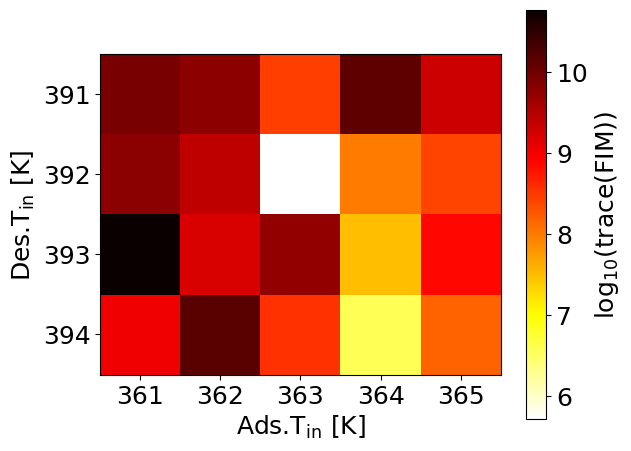

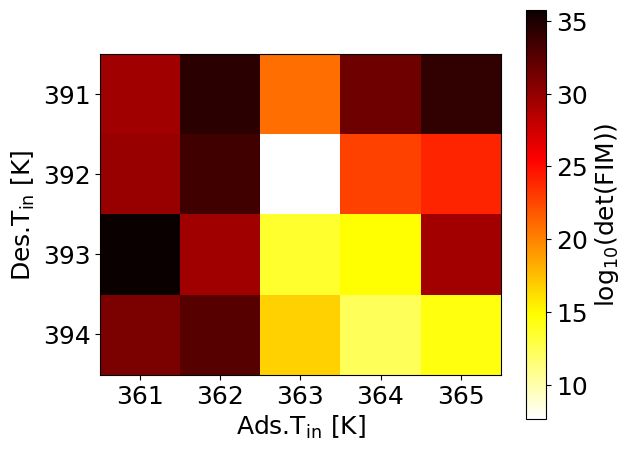

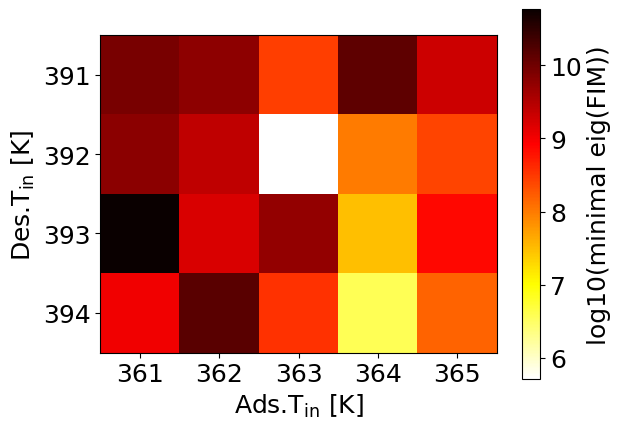

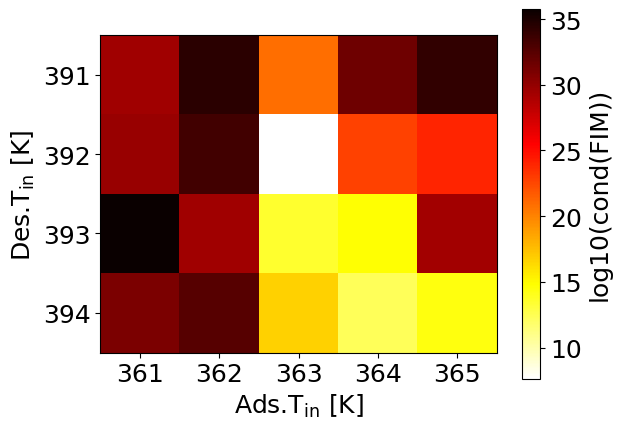

In [22]:
# specify x, y ranges
x_range = [361, 362, 363, 364, 365]
y_range = [391, 392, 393, 394]


heatmap(res_a, res_d, "heatmap-", "Ads.T$_{in}$ [K]", "Des.T$_{in}$ [K]", log_scale=False, 
        save="heatmap-")

In [ ]:
""